In [2]:
import os
import sys
import umap
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm import tqdm

sys.path.append('../')
from util.xai_utils import *

In [11]:
str_to_int_label = {'edge-iot': ['benign',
  'dos-http',
  'dos-icmp',
  'dos-tcp-syn',
  'dos-udp',
  'infog-scan-os',
  'infog-scan-port',
  'infog-scan-vuln',
  'inject-http',
  'inject-sql',
  'inject-xss',
  'malwr-backd-tcp',
  'malwr-brutef-http',
  'malwr-ransomware'],
 'iot-nidd': ['benign',
  'dos-http',
  'dos-tcp-ack',
  'dos-tcp-syn',
  'dos-udp',
  'infog-scan-host',
  'infog-scan-os',
  'infog-scan-port',
  'malwr-brutef-telnet',
  'mitm-arpspoof'],
 'ton-iot': ['benign',
  'dos-http',
  'dos-tcp',
  'dos-tcp-syn',
  'infog-scan-port',
  'inject-sql',
  'inject-xss',
  'malwr-backd-tcp',
  'malwr-brutef-ftp',
  'malwr-brutef-http',
  'malwr-ransomware',
  'mitm-arpspoof']}

In [12]:
def f(x, features):
    return np.concatenate([v.tolist() for i, v in enumerate(x)])

def obtain_inputs(edge, nidd, ton, category, featuress):

    edge = edge[edge['ENC_LABEL']==str_to_int_label['edge-iot'].index(category)]
    nidd = nidd[nidd['ENC_LABEL']==str_to_int_label['iot-nidd'].index(category)]
    ton = ton[ton['ENC_LABEL']==str_to_int_label['ton-iot'].index(category)]
    
    X_edge, X_nidd, X_ton = [], [], []

    if len(edge):
        X_edge = edge[featuress[0]].apply(lambda x: f(x, featuress[0]), axis=1)
        X_edge = np.array([[vv for vv in v] for v in X_edge])

    if len(nidd):
        X_nidd = nidd[featuress[0]].apply(lambda x: f(x, featuress[0]), axis=1)
        X_nidd = np.array([[vv for vv in v] for v in X_nidd])

    if len(ton):
        X_ton = ton[featuress[0]].apply(lambda x: f(x, featuress[0]), axis=1)
        X_ton = np.array([[vv for vv in v] for v in X_ton])
    return X_edge, X_nidd, X_ton

def obtain_dataframe(X_edge, X_nidd, X_ton):
    df = pd.DataFrame(columns=['x','y','dataset'])

    try:
        X = np.array(X_edge)
        for dataset in [X_nidd, X_ton]:
            if len(dataset):
                X = np.concatenate((X, dataset))
        labels = ['Edge-IIoT']*len(X_edge) + ['IoT-NIDD']*len(X_nidd) + ['ToN-IoT']*len(X_ton)
    except:
        print('[ERROR] Concatenate dataset not sucessed!')
    
    X_embedded = umap.UMAP(n_components=2, random_state=42).fit_transform(X)
    df['x'] = X_embedded[:,0]
    df['y'] = X_embedded[:,1]
    df['dataset'] = labels
    return df

def plot_umap(df, savefig):
        fig, ax = plt.subplots(1,1,figsize=(7,7))
        plt.rcParams['font.size']=18
        g = sn.kdeplot(data=df, x='x', y='y', hue='dataset',legend=False, space=0, height=7,ax=ax,
                levels=3, thresh=.5, common_norm=False, bw_adjust=.5, fill=True,palette=[sn.color_palette('viridis')[0], sn.color_palette('viridis')[2], sn.color_palette('viridis')[4]],
                        alpha=.8)

        legend_elements = [
                        Line2D([0], [0], marker='s', color='w', label='Edge-IIoT',
                                markerfacecolor=sn.color_palette('viridis')[0], markersize=12, markeredgecolor='black'),
                        Line2D([0], [0], marker='s', color='w', label='IoT-NIDD',
                                markerfacecolor=sn.color_palette('viridis')[2], markersize=12, markeredgecolor='black'),
                        Line2D([0], [0], marker='s', color='w', label='ToN-IoT',
                                markerfacecolor=sn.color_palette('viridis')[4], markersize=12, markeredgecolor='black'),
                        ]
        plt.legend(handles=legend_elements, ncol=3, bbox_to_anchor=(1.3,1.3), frameon=False,
                handletextpad=0.1, columnspacing=0.4)
        plt.savefig(f'UMAP/fig_{savefig}.pdf', dpi=300, bbox_inches='tight')
        plt.show()

In [13]:
dataset_paths = {
    'iot-nidd': '../../data/uniform_label/iot-nidd_dwn10p_prep1.parquet',
    'edge-iiot': '../../data/uniform_label/edge-iiot_dwn10p_prep1.parquet',
    'ton-iot': '../../data/uniform_label/ton-iot_dwn10p_prep1.parquet',
}

dataset_ids = {
    'edge-iiot': 'EDG',
    'iot-nidd': 'NID',
    'ton-iot': 'TON',
}

featuress = [['SCALED_PL', 'SCALED_IAT', 'SCALED_DIR', 'SCALED_WIN']]

In [14]:
df_edge = pd.read_parquet(dataset_paths['edge-iiot'])
df_nidd = pd.read_parquet(dataset_paths['iot-nidd'])
df_ton = pd.read_parquet(dataset_paths['ton-iot'])

  0%|          | 0/4 [00:00<?, ?it/s]

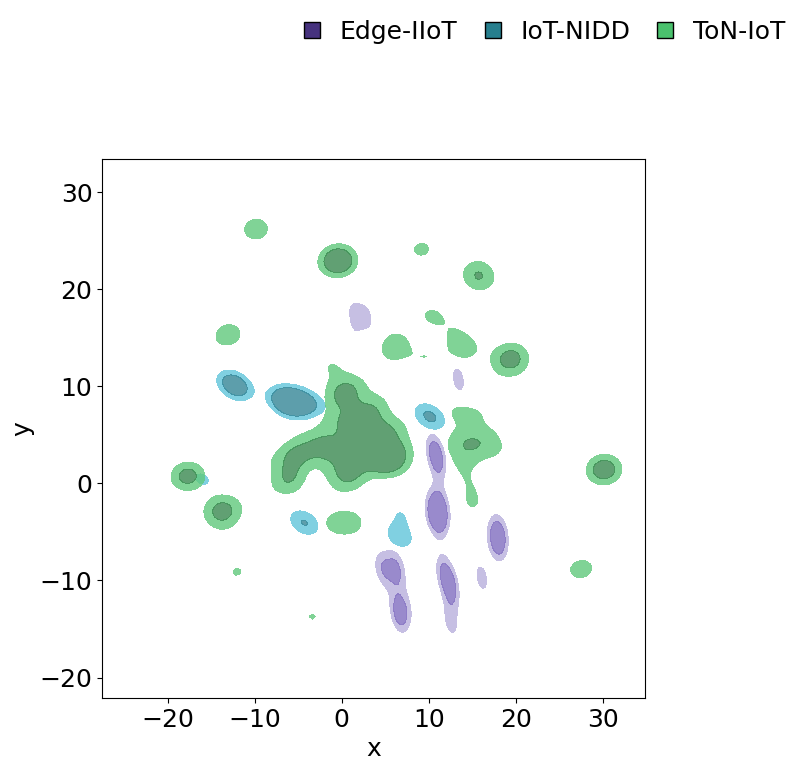

 25%|██▌       | 1/4 [00:14<00:43, 14.61s/it]

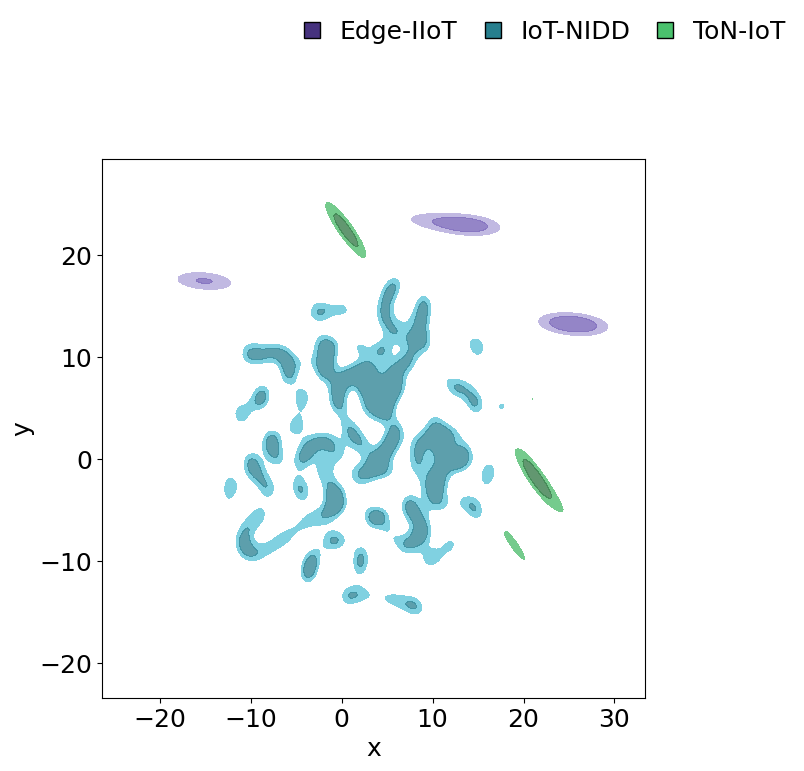

 50%|█████     | 2/4 [00:34<00:35, 17.92s/it]

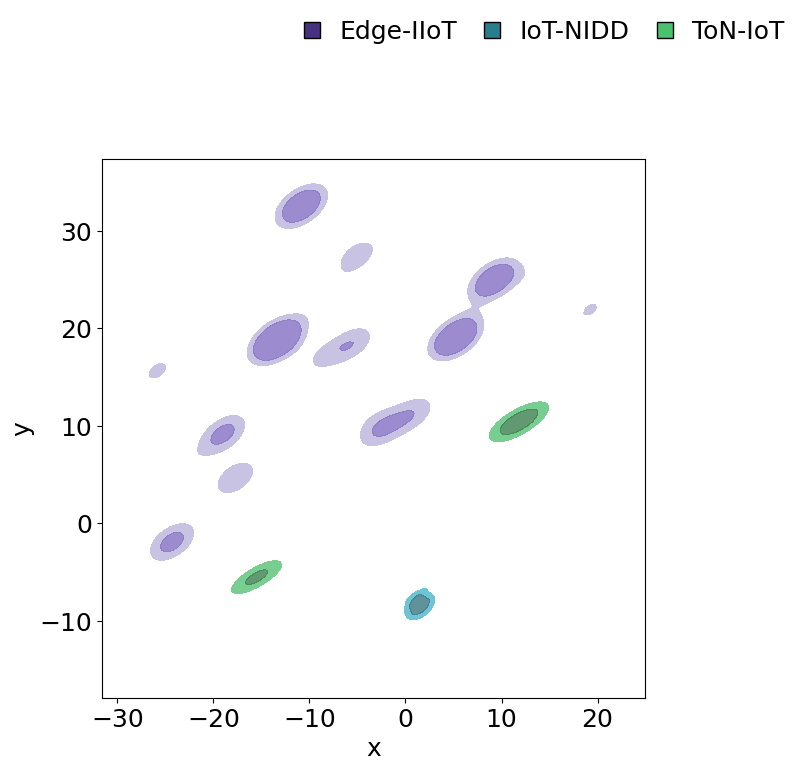

 75%|███████▌  | 3/4 [00:46<00:15, 15.22s/it]

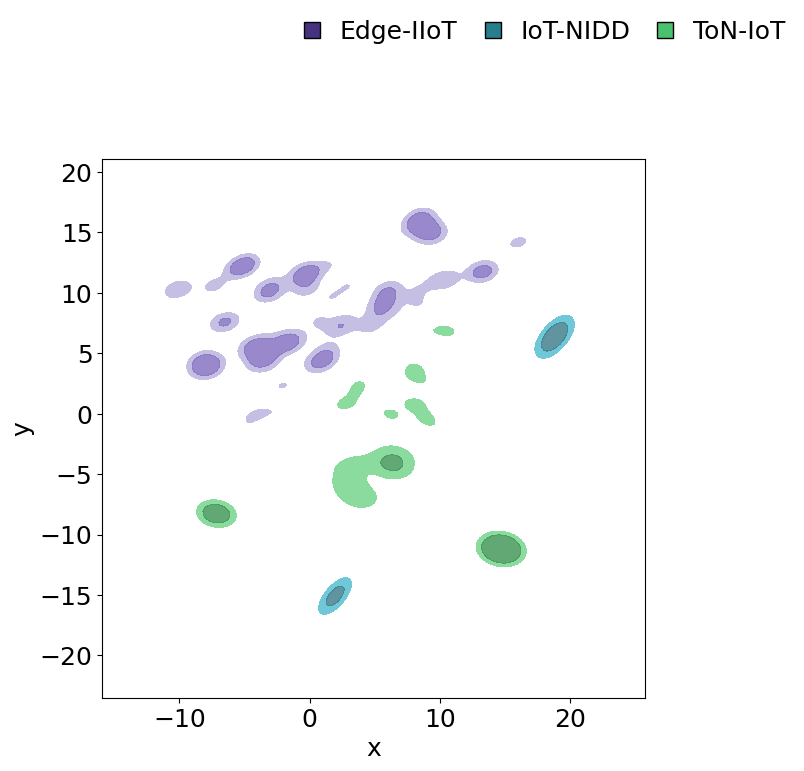

100%|██████████| 4/4 [01:21<00:00, 20.41s/it]


In [15]:
os.makedirs('UMAP', exist_ok=True)

for attack_classes in tqdm(['dos-http', 'dos-tcp-syn', 'infog-scan-port', 'benign']):
    X_edge, X_nidd, X_ton = obtain_inputs(df_edge, df_nidd, df_ton, attack_classes, featuress)
    df=obtain_dataframe(X_edge, X_nidd, X_ton)
    plot_umap(df, attack_classes)
    df.to_parquet(f'UMAP/umap_{attack_classes}.parquet')